In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

C:\Users\dasum\AppData\Local\Temp\ipykernel_25324\2393859339.py:61: RuntimeWarning: overflow encountered in scalar subtract
  if (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2:
C:\Users\dasum\AppData\Local\Temp\ipykernel_25324\2393859339.py:61: RuntimeWarning: overflow encountered in scalar add
  if (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2:


Moneda de referencia seleccionada en (128,346) con radio 87px


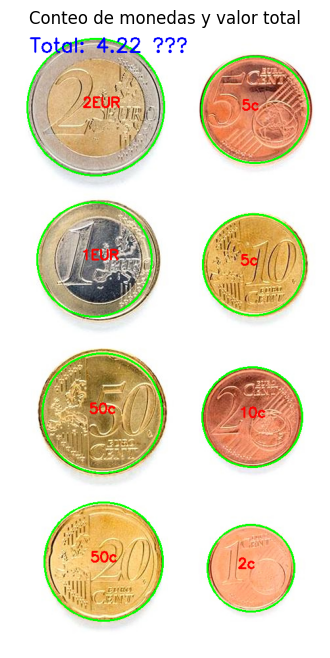


Resumen de detección:
1 x 2EUR
2 x 5c
2 x 50c
1 x 10c
1 x 1EUR
1 x 2c
Total = 4.22 EUR


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Tabla de referencia de monedas (diámetros en mm)
monedas_info = {
    "2EUR": 25.75,
    "1EUR": 23.25,
    "50c": 24.35,
    "20c": 22.25,
    "10c": 19.75,
    "5c": 21.25,
    "2c": 18.75,
    "1c": 16.25
}

monedas_valor = {
    "2EUR": 2.00,
    "1EUR": 1.00,
    "50c": 0.50,
    "20c": 0.20,
    "10c": 0.10,
    "5c": 0.05,
    "2c": 0.02,
    "1c": 0.01
}

# --- Carga imagen
img = cv2.imread("monedas.jpg")
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(gris, 7)

# --- Detecta círculos con Hough
circ = cv2.HoughCircles(
    pimg,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=60,
    param1=100,
    param2=50,
    minRadius=20,
    maxRadius=150
)

if circ is None:
    print("No se detectaron monedas.")
    exit()

circ = np.uint16(np.around(circ[0, :]))
img_vista = img.copy()

# Variables globales para la referencia
escala = None
moneda_ref = None

# --- Función callback para clic del ratón
def seleccionar_referencia(event, x, y, flags, params):
    global escala, moneda_ref
    if event == cv2.EVENT_LBUTTONDOWN:
        for (cx, cy, r) in circ:
            if (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2:
                moneda_ref = (cx, cy, r)
                diam_px = 2 * r
                escala = 23.25 / diam_px  # asumimos que la moneda clicada es de 1€
                print(f"Moneda de referencia seleccionada en ({cx},{cy}) con radio {r}px")
                break

# --- Mostrar ventana para clic
cv2.namedWindow("Selecciona moneda de 1€")
cv2.setMouseCallback("Selecciona moneda de 1€", seleccionar_referencia)

while True:
    vista = img_vista.copy()
    # Dibujar todos los círculos detectados
    for (cx, cy, r) in circ:
        cv2.circle(vista, (cx, cy), r, (0, 255, 0), 2)
    # Si ya hay referencia, marcarla en rojo
    if moneda_ref is not None:
        cx, cy, r = moneda_ref
        cv2.circle(vista, (cx, cy), r, (0, 0, 255), 3)
    cv2.imshow("Selecciona moneda de 1€", vista)
    key = cv2.waitKey(1) & 0xFF
    if key == 27 or escala is not None:  # presiona ESC o haz clic
        break

cv2.destroyAllWindows()

# --- Procesamiento posterior
if escala is None:
    print("No seleccionaste moneda de referencia.")
    exit()

# --- Procesar todas las monedas detectadas
total = 0
cuenta = {}
img_out = img.copy()

for (cx, cy, r) in circ:
    diam_mm = (2 * r) * escala
    # Buscar la moneda más cercana en la tabla
    moneda_clase = min(monedas_info.keys(),
                       key=lambda k: abs(monedas_info[k] - diam_mm))
    valor = monedas_valor[moneda_clase]
    total += valor
    cuenta[moneda_clase] = cuenta.get(moneda_clase, 0) + 1

    # Dibuja círculo y etiqueta
    cv2.circle(img_out, (cx, cy), r, (0, 255, 0), 2)
    cv2.putText(img_out, f"{moneda_clase}",
                (cx - 20, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                (0, 0, 255), 2)

# --- Mostrar total
cv2.putText(img_out, f"Total: {total:.2f} €",
            (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
            (255, 0, 0), 2)

# --- Visualización final
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Conteo de monedas y valor total")
plt.show()

# --- Mostrar resumen por consola
print("\nResumen de detección:")
for m, c in cuenta.items():
    print(f"{c} x {m}")
print(f"Total = {total:.2f} EUR")

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.
